### 2018/2019 - Task List 6

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)


1. Reimplement Task List 4 using automatic guide building, remember about code fixes (`with pyro.plate...`)
2. Visualize infered and given distributions
3. Explore hyperparameters in Task List 5
 - change learning rate
 - plot changes of loss for different learning rates
 - use different optimizers (at least two) ajd explore their parameters 
4. What will happen if you will set extremally low prior distribution parameters (`0.000000001`, mean, std)


## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.optim import Adam
from pyro.optim import Adagrad
from pyro.optim import Adamax
from scipy.stats import norm

In [2]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

In [3]:
wineData = pd.read_table('wine.csv', sep=',')

In [4]:
data = torch.FloatTensor(wineData.alcalinity_of_ash.values)
print("mean:\t",(wineData.alcalinity_of_ash.values).mean())
print("avg:\t",(wineData.alcalinity_of_ash.values).std())

mean:	 19.49494382022472
avg:	 3.3301697576582128


In [5]:
prior_mean=25.0
noise_std=5.0

def model(data):  # equivalent to conditioned_scale above
    prior=pyro.distributions.Normal(prior_mean, 1.)
    weight = pyro.sample("weight", prior)
    with pyro.plate("map", len(data)):
        pyro.sample("measurement", pyro.distributions.Normal(weight, noise_std), obs=data)
        
optim = Adam({"lr": 0.1})
svi = pyro.infer.SVI(model=model,
                     guide=AutoDiagonalNormal(model),
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

pyro.clear_param_store()
losses, mean  = [], []
num_steps = 2000
t=tqdm(range(num_steps))
for j in t:
    loss = svi.step(data)
    losses.append(loss)
    t.set_postfix(loss=loss)

100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 149.14it/s, loss=504]


In [6]:
x = []
for name, value in pyro.get_param_store().items():
    x.append(value[0])
    print(name, value[0])

auto_loc tensor(20.1835, grad_fn=<SelectBackward>)
auto_scale tensor(0.3471, grad_fn=<SelectBackward>)


Text(0, 0.5, 'loss')

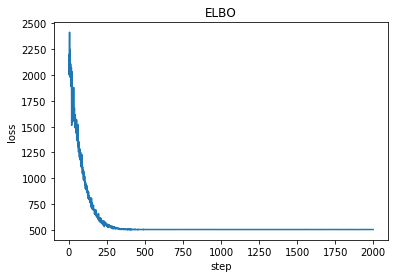

In [7]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


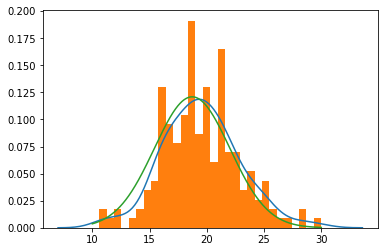

In [8]:
sns.kdeplot(wineData.alcalinity_of_ash.values, shade=False)
plt.hist(np.array(wineData.alcalinity_of_ash.values), density=True, bins=30)
x_axis = np.arange(10, 30, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 18.72, 3.3))
plt.show()


In [9]:
a=2.0
b=3.0
noise_mean=0
noise_std=10
count=50

In [10]:
base=torch.arange(0, count).type(torch.FloatTensor)
with pyro.plate("noise_plate", count):
    noise=pyro.sample("noise", pyro.distributions.Normal(noise_mean, noise_std))

x=base
y=x*a+b+noise

In [11]:
x_data=x[:,None]
y_data=y[:,None]

In [12]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.a = nn.Linear(1, 1, bias=False)
        self.b = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.a(x) + self.b

In [13]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        a_prior = pyro.distributions.Normal(torch.ones(1, 1)*3*0.000000001, torch.ones(1, 1)*0.000000001).to_event(1)
        b_prior = pyro.distributions.Normal(2.*0.000000001, 1000.*0.000000001)
        priors = {'a.weight': a_prior, 'b': b_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 1000.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model

In [14]:
def train(p_optim):
    pyro.clear_param_store()
    num_iterations=1000
    model = create_probabilistic_model()
    guide = AutoDiagonalNormal(model)
    optim = p_optim
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    lqwe = []
    for j in t:
        loss = svi.step(x_data, y_data.squeeze(-1))
        lqwe.append(loss)
        t.set_postfix(loss=loss)
    return lqwe

In [15]:
l1 = train(pyro.optim.Adam({"lr": 0.1}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.53it/s, loss=5.87e+13]


Text(0, 0.5, 'loss')

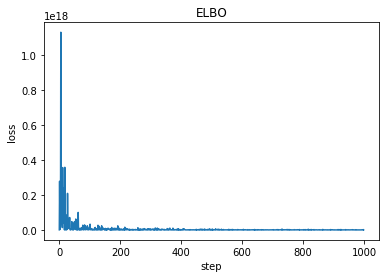

In [16]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [17]:
l1 = train(pyro.optim.Adam({"lr": 0.01}))

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 98.19it/s, loss=7.26e+15]


Text(0, 0.5, 'loss')

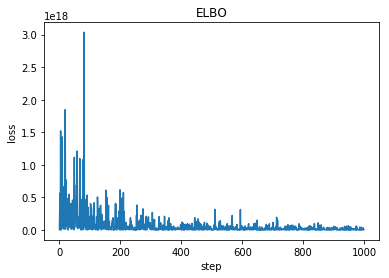

In [18]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [19]:
l1 = train(pyro.optim.Adam({"lr": 0.001}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.74it/s, loss=7.97e+16]


Text(0, 0.5, 'loss')

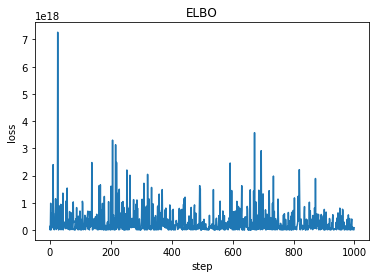

In [20]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [21]:
l1 = train(pyro.optim.Adagrad({"lr": 0.1}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.73it/s, loss=2.86e+16]


Text(0, 0.5, 'loss')

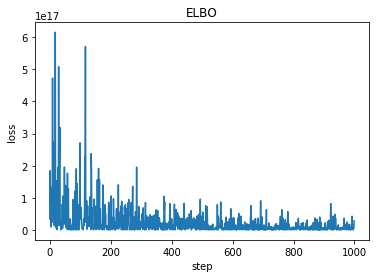

In [22]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [23]:
l1 = train(pyro.optim.Adagrad({"lr": 0.1, "lr_decay":0.1}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 103.87it/s, loss=4.61e+17]


Text(0, 0.5, 'loss')

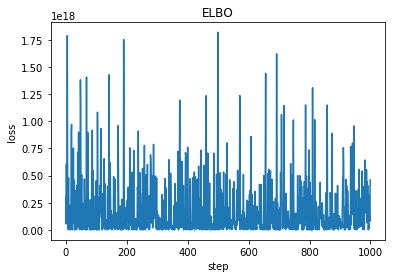

In [24]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [25]:
l1 = train(pyro.optim.Adagrad({"lr": 0.7, "lr_decay":0.001}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.97it/s, loss=1.31e+15]


Text(0, 0.5, 'loss')

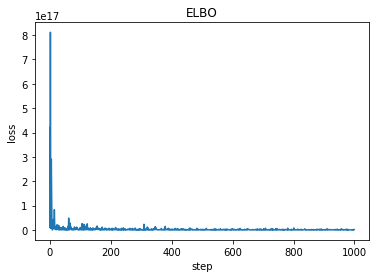

In [26]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [27]:
l1 = train(pyro.optim.Adagrad({"lr": 0.7, "lr_decay":0.1}))

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.45it/s, loss=1.29e+16]


Text(0, 0.5, 'loss')

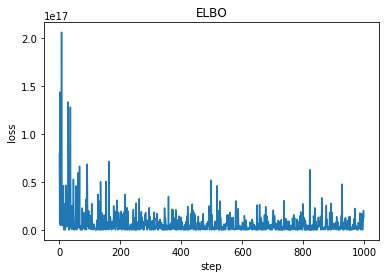

In [28]:
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.82it/s, loss=4.96e+14]


Text(0, 0.5, 'loss')

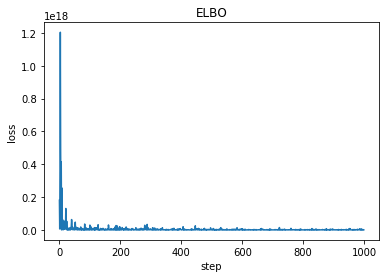

In [29]:
l1 = train(pyro.optim.Adamax({"lr": 0.3}))
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.74it/s, loss=1.79e+14]


Text(0, 0.5, 'loss')

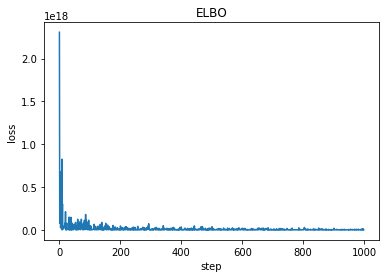

In [30]:
l1 = train(pyro.optim.Adamax({"lr": 0.3, "eps": 0.1}))
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 97.46it/s, loss=5.97e+14]


Text(0, 0.5, 'loss')

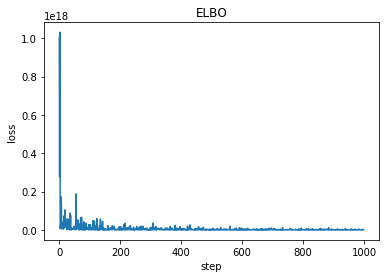

In [31]:
l1 = train(pyro.optim.Adamax({"lr": 0.3, "eps": 0.001}))
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

100%|███████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.37it/s, loss=3.91e+14]


Text(0, 0.5, 'loss')

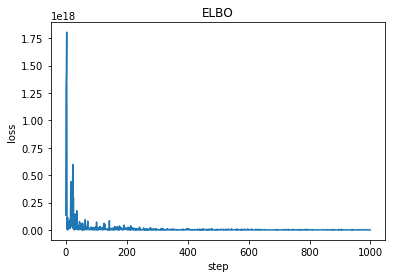

In [32]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):
        # weight and bias priors
        a_prior = pyro.distributions.Normal(torch.ones(1, 1)*3*0.000000001, torch.ones(1, 1)*0.000000001).to_event(1)
        b_prior = pyro.distributions.Normal(2.*0.000000001, 1000.*0.000000001)
        priors = {'a.weight': a_prior, 'b': b_prior}
        scale = pyro.sample("sigma", pyro.distributions.Uniform(0., 1000.))
        # lift module parameters to random variables sampled from the priors
        lifted_module = pyro.random_module("module", regression_model, priors)
        # sample a nn (which also samples w and b)
        lifted_reg_model = lifted_module()
        with pyro.plate("map", len(x_data)):
            # run the nn forward on data
            prediction_mean = lifted_reg_model(x_data).squeeze(-1)
            # condition on the observed data
            obs=pyro.sample("obs",
                        pyro.distributions.Normal(prediction_mean, scale),
                        obs=y_data)
            return prediction_mean
    return probabilistic_model

l1 = train(pyro.optim.Adam({"lr": 0.1}))
plt.plot(l1)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [33]:
x = []
for name, value in pyro.get_param_store().items():
    x.append(value[0])
    print(name, value[0])

auto_loc tensor(-2.7257, grad_fn=<SelectBackward>)
auto_scale tensor(0.1108, grad_fn=<SelectBackward>)
